# When working with Neural networks, backpropagation needs to be performed. In practice, it is done using the command:
  - loss.backward()
  - backward() is a Pytorch functionality that does backporpagation for us.


## But what really happens under the hood?
  - Pytoch uses a library called AutoGrad to do backpropagation.

## To get a real feel for back propagation, Andrej Karpathy devoloped Micrograd which is very similar to autograd in its functionality. This notebook is a re-implementation of Andrej's MicroGrad with clear explanations.

In [ ]:
### A Neural Netowrk is simply a huge mathematical expression (or rather humongous).
#       The mathematical operations involved inside a neural net consists of simple
#       additions, subtractions, multiplications and some non-linearities (like tanh).
#
### Each of the above operations is differentiable. So, gradients exist. The expression
#       is optimized to reduce the loss of the neural net. To optimize, the network has
#       has some parameters to adjust. The whole point of back propagation is to use the
#       gradients to adjust these parameters, so that the loss is minimized. This process
#       is demonstrated using simple scalar operations given below.

In [ ]:
# All necessary libraries are imported
import math
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# A python function. A mathematical function implementation.
def f(x):
  return 3*x**2 - 4*x + 5

In [ ]:
f(3.0)

20.0

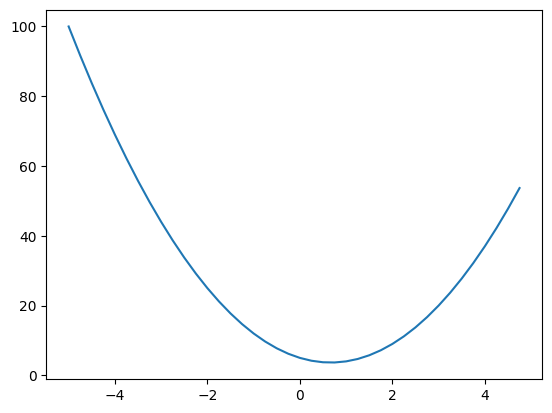

In [ ]:
# Plotting the function
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

In [ ]:
# Visualization of mathematical expression using graphs. This code is the graph builder
import graphviz

from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [ ]:
# A class named value is introduced. Simply these are numbers with an attribute named 'gradient'.
class Value:

    def __init__(self,data, _children=(), _op='', label=''):                    # Value has data in it, its children, the operation and the label.
        self.data = data                                                        #   Eg: Value(a) + Value(b) = Value(c)
        self._prev = set(_children)                                             #       Value(c) has data:c
        self._backward = lambda: None                                           #                children:a,b
        self.grad = 0.0                                                         #                   label:'c'
        self._op = _op                                                          #                      op:'+'
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self,other):                                                    # Keeping track of gradient of output with respect to inputs
        other = other if isinstance(other, Value) else Value(other)             #   in the execution of addition operation ('+').
        out = Value(self.data + other.data, (self, other), "+")
        def _backward():                                                        # When _backward() is called, the gradients are calculated and
            self.grad += out.grad                                               #    and stored. Precisely here, if loss = f(out) and
            other.grad += out.grad                                              #    self + other = out, then
        out._backward = _backward                                               #    d(loss)/d(self) = d(loss)/d(out) * d(out)/d(self). Which means
        return out                                                              #       self.grad    =    out.grad    *     1.0

    def __radd__(self,other):
        return self+other

    def __rsub__(self,other):
        return self-other

    def __sub__(self,other):
        return self+ (-other)

    def __neg__(self,other):
        return self*(-1)

    '''
    a = Value(#)
    b = Value(#)
    a+b is internally interpreted by python as a.__add__(b)
    '''
    def __mul__(self,other):
        other = other if isinstance(other, Value) else Value(other)             # Similar to addition, multiplication is another operation and
        out = Value(self.data*other.data, (self,other), "*")                    #   gradients are kept track of.
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out

    def __rmul__(self,other):
        return self*other

    def __truediv__(self,other):
        return self*other**(-1)

    def __pow__(self,other):
        assert isinstance(other,(int,float))
        out = Value(self.data**other,(self,),f'**{other}')                      # d(x**(a))/d(a) = a*x**(a-1)
        def _backward():
            self.grad += other*(self.data**(other-1))*out.grad
        out._backward = _backward
        return out

    def tanh(self):
        x = self.data
        t = (math.exp(2*x)-1)/(math.exp(2*x)+1)                                 # d(tanhx)/dx = 1 - (tanhx)**2
        out = Value(t,(self,),'tanh')
        def _backward():
            self.grad += (1 - t**2)*out.grad
        out._backward = _backward
        return out

    def exp(self):
        x = self.data
        t = math.exp(x)
        out = Value(t,(self,),'exp')                                            # d(exp(x))/dx = exp(x)
        def _backward():
            self.grad += t * out.grad
        out._backward = _backward
        return out

    def backward(self):

        topo = []
        visited = set()                                                         # After the entire mathematical operation is performed, the
        def build_topo(v):                                                      #   operations are arranged in the order they are performed
            if v not in visited:                                                #   for the gradients to flow backward correctly. The code
                visited.add(v)                                                  #   here says to add a node to the list of nodes only after
                for child in v._prev:                                           #   all its children nodes are added.
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1.0

        for node in reversed(topo):                                             # Once the nodes are sorted, backward pass is done through the
            node._backward()                                                    #   entire expression.


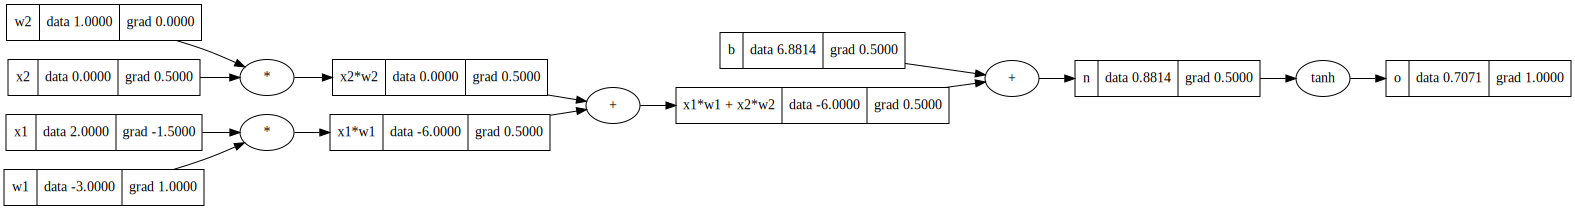

In [ ]:
# inputs
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights and biases
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
b = Value(6.8813735870195432, label='b')
#neuron operation
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'
o.backward()                                                                    # Magic happens when this line is called. All gradients just
draw_dot(o)                                                                     #     flew backward when this is called.


In [ ]:
class Neuron:

    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]              # A neuron is simply a mathematical operation similar to the ones
        self.b = Value(random.uniform(-1,1))                                    #   implemented above. The call method states out the operation.

    def __call__(self,x):
        act = sum((wi*xi for wi, xi in zip(self.w,x)), self.b)
        out = act.tanh()
        return out
    def parameters(self):
        return self.w + [self.b]

class Layer:                                                                    # To put some meat in the maths, a layer is introduced which is a
                                                                                #    bunch of neurons stacked up and process paralelly.
    def __init__(self,nin,nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self,x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs)==1 else outs

    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]


class MLP:                                                                      # A bunch of layers connected to each other make up a Neural Network

    def __init__(self,nin, nouts):                                              #  MLP stands for Multi-Layer-Perceptron which simply means a
        sz = [nin] + nouts                                                      #  multiple layered neurons.
        self.layers = [Layer(sz[i],sz[i+1]) for i in range(len(nouts))]

    def __call__(self,x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [ ]:
net = MLP(3,[4,4,1])

In [ ]:
#inputs
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

In [ ]:
#Finally, the network is implemeted and parameters are updated 200 times in the direction of negative gradient.
#   The parameters go downhill in the loss curve when they move in the direction of negative gradient.
for k in range(200):

    #forward pass
    ypred = [net(x) for x in xs]
    loss = sum((ygt - yout)**2 for yout,ygt in zip(ypred,ys))

    #backward pass
    for p in net.parameters():
        p.grad =0.0
    loss.backward()

    #update parameters
    for p in net.parameters():
        p.data += -0.1*p.grad

    print(k,loss.data)

0 5.727530792042895
1 2.2611638879236478
2 1.3695358137097995
3 0.899521098947636
4 0.20763863272233246
5 0.1345955250395221
6 0.1097952669536669
7 0.09284437814087956
8 0.08020391307079591
9 0.07039401915479103
10 0.06257075742692142
11 0.05619825405603311
12 0.05091668985693566
13 0.046475063478751154
14 0.04269300747670221
15 0.039437694830039075
16 0.03660924531036623
17 0.03413118172572023
18 0.03194400868486805
19 0.030000785670342357
20 0.028264009270190765
21 0.026703375546408656
22 0.025294146717159613
23 0.024015940660172763
24 0.022851821317329938
25 0.021787606558686855
26 0.0208113354251908
27 0.019912853694050228
28 0.019083488331990875
29 0.018315789457055098
30 0.017603324092722944
31 0.016940510031743926
32 0.01632248103504596
33 0.015744976711309002
34 0.015204251984984693
35 0.014697002222945323
36 0.01422030096287122
37 0.013771547847719084
38 0.013348424875586719
39 0.012948859462897647
40 0.012570993120063503
41 0.01221315477389485
42 0.011873837955727962
43 0.011

In [ ]:
ypred

[Value(data=0.9805039293129436),
 Value(data=-0.9942674945252521),
 Value(data=-0.9696580210497071),
 Value(data=0.9743869211943179)]